# WGAN-autoencoder
We use the adversarial autoencoder (https://arxiv.org/pdf/1511.05644.pdf) to encode data, the Wasserstein-GAN (https://arxiv.org/pdf/1704.00028v3.pdf) works in the new (encoded) space.
The generator model generates samples from latent space to the encoded space, the discriminator model distinguishes real and fake samples in the encoded space. The decoding is used after generation in order to represent samples from the encoded space to the initial space.

In [6]:
from collections import OrderedDict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.utils import shuffle
import matplotlib
import torch.autograd as autograd
import random
import torch.autograd as autograd
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics
import h5py
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

import torch.distributions.multivariate_normal as mn
import math
import pickle


import torch.autograd as autograd
from sklearn.preprocessing import StandardScaler

from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf

random_seed = 99
torch.manual_seed(random_seed)
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else "cpu")

In [7]:
batch_size = 128
lr = 1e-4 # learning rate
seq_len = 5000 # initial space
emb_dim = seq_len // 16 # encoded space
random_dim = 32  # latent space for the generator model
epochs_autoen = 50 #epochs to train autoencoder
ITERS = 1000 # iterations to train WGAN
CRITIC_ITERS = 5
LAMBDA = 10 # penalty

## 1. Preprocessing

In [3]:
pulses = pickle.load(open('/Users/nzaretski/Desktop/gerda/CNN_GAN_Ge/data/raw/data.pkl','rb'))
pulses = pulses.astype(float)

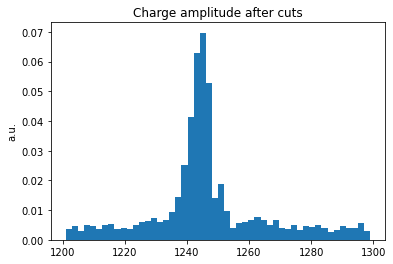

In [4]:
plt.hist(np.max(pulses, axis = 1) - np.min(pulses, axis = 1), bins = 50, density=True)
plt.title('Charge amplitude after cuts')
plt.ylabel('a.u.')
plt.show()

Text(0, 0.5, 'a.u.')

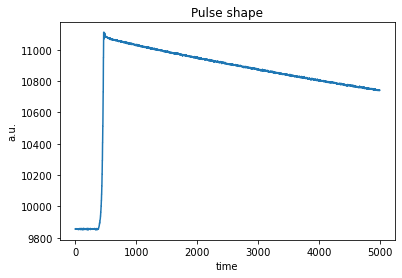

In [5]:
plt.plot(pulses[1])
plt.title('Pulse shape')
plt.xlabel('time')
plt.ylabel('a.u.')

In [3]:
scaler = StandardScaler()
pulses = scaler.fit_transform(pulses)


pickle.dump(scaler, open('scaler.pkl','wb'))

In [4]:
train_data_length = pulses.shape[0]
train_data = torch.zeros((train_data_length, 3748))
train_data = torch.tensor(pulses, dtype=torch.float)
train_labels = torch.zeros(train_data_length, 1)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

## 1. Models

In [9]:
class Encoder(nn.Module):
    def __init__(self, seq_len, emb_dim):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(            
            nn.Conv1d(self.seq_len, self.seq_len // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 2, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 4, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 8, self.emb_dim, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return output.squeeze(-1)

In [10]:
class Decoder(nn.Module):
    def __init__(self, seq_len, emb_dim):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.emb_dim, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 8, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False),
      )
    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

In [11]:
class Discriminator(nn.Module):   
    def __init__(self, emb_dim):
        super(Discriminator, self).__init__()
        self.emb_dim = emb_dim
        self.model = nn.Sequential(            
            nn.Conv1d(self.emb_dim, self.emb_dim // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 2, self.emb_dim // 4, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 4, self.emb_dim // 8, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(self.emb_dim // 8, self.emb_dim // 16, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.emb_dim // 16, 1, 1, bias=False),
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return output.squeeze(-1)

In [12]:
class Generator(nn.Module):
    def __init__(self, emb_dim, random_dim):
        super(Generator, self).__init__()
        self.emb_dim = emb_dim
        self.random_dim = random_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.random_dim, self.emb_dim // 8, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.emb_dim // 8, self.emb_dim // 4, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.emb_dim // 4, self.emb_dim // 2, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.emb_dim // 2, self.emb_dim, 1, bias=False),
      )
    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

In [ ]:
class PriorDiscriminator(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.l0 = nn.Linear(self.emb_dim, 64)
        self.l1 = nn.Linear(64, 64//4)
        self.l2 = nn.Linear(64//4, 1)
        
    def forward(self, x):
        h = F.leaky_relu(self.l0(x))
        h = F.leaky_relu(self.l1(h))
        return torch.sigmoid(self.l2(h))

# Adversarial Autoencoder

In [15]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(DEVICE)

mps


In [16]:
encoder = Encoder(seq_len, emb_dim).to(DEVICE)
decoder = Decoder(seq_len, emb_dim).to(DEVICE)
disc = PriorDiscriminator(emb_dim).to(DEVICE)
recon_loss = nn.MSELoss(reduction = 'sum').to(DEVICE)

In [17]:
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=1e-3)
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=1e-3)

optim_encoder_reg = torch.optim.Adam(encoder.parameters(), lr=1e-3)
optim_D = torch.optim.Adam(disc.parameters(), lr=1e-3)

In [18]:
loss_ep = []
losses = []
start_time = time.time()
one = torch.FloatTensor([1])
mone = one * -1
one = one.to(DEVICE)
mone = mone.to(DEVICE)
for epoch in range(epochs_autoen):
    for i, (x, y) in enumerate(train_loader):
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        batch = x.size(0)
        
        encoder.train()
        decoder.train()
        disc.train()
        
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()
        
        #Reconstruction phase
        z = encoder(x)
        x_hat = decoder(z)
        loss = recon_loss(x_hat,x)
        loss.backward()
        optim_encoder.step()
        optim_decoder.step()

        #Discriminator phase
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()
        encoder.eval()
        
        z_real_gauss = autograd.Variable(torch.randn(z.size())*1).to(DEVICE)
        z_fake_gauss = encoder(x)
        
        D_real_gauss, D_fake_gauss = disc(z_real_gauss), disc(z_fake_gauss.detach())
        
        real_outputs = D_real_gauss.mean(dim=0)
        real_outputs.backward(mone)
        fake_outputs = D_fake_gauss.mean(dim=0)
        fake_outputs.backward(one)
        optim_D.step()
        
        #Regularization phase
        encoder.zero_grad()
        decoder.zero_grad()
        disc.zero_grad()

        encoder.train()
        z = encoder(x)
        D_fake_gauss = disc(z)
        fake_outputs = D_fake_gauss.mean(dim=0)
        fake_outputs.backward(mone)
        optim_encoder_reg.step()
        
        if i % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(x), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))
            
        if (i == len(train_loader) - 1): # per epoch 
            loss_ep.append(loss.item())        
        
        losses.append(loss.item())        


    if epoch == 0:
        print("---1 epoch: %s seconds ---" % (time.time() - start_time))

Train Epoch: 0 [0/2619 (0%)]	Loss: 421223.750000
---1 epoch: 7.9569621086120605 seconds ---
Train Epoch: 1 [0/2619 (0%)]	Loss: 85412.984375
Train Epoch: 2 [0/2619 (0%)]	Loss: 39490.460938
Train Epoch: 3 [0/2619 (0%)]	Loss: 566718.875000
Train Epoch: 4 [0/2619 (0%)]	Loss: 45363.007812
Train Epoch: 5 [0/2619 (0%)]	Loss: 690080.500000
Train Epoch: 6 [0/2619 (0%)]	Loss: 157920.437500
Train Epoch: 7 [0/2619 (0%)]	Loss: 185461.437500
Train Epoch: 8 [0/2619 (0%)]	Loss: 216336.531250
Train Epoch: 9 [0/2619 (0%)]	Loss: 105601.335938
Train Epoch: 10 [0/2619 (0%)]	Loss: 112241.765625
Train Epoch: 11 [0/2619 (0%)]	Loss: 45333.875000
Train Epoch: 12 [0/2619 (0%)]	Loss: 336828.375000
Train Epoch: 13 [0/2619 (0%)]	Loss: 75200.804688
Train Epoch: 14 [0/2619 (0%)]	Loss: 40337.019531
Train Epoch: 15 [0/2619 (0%)]	Loss: 20383.886719
Train Epoch: 16 [0/2619 (0%)]	Loss: 43948.414062
Train Epoch: 17 [0/2619 (0%)]	Loss: 46300.917969
Train Epoch: 18 [0/2619 (0%)]	Loss: 33666.988281
Train Epoch: 19 [0/2619 (0%

In [37]:
torch.save(decoder.state_dict(), 'wgan_auto_decoder.pth')

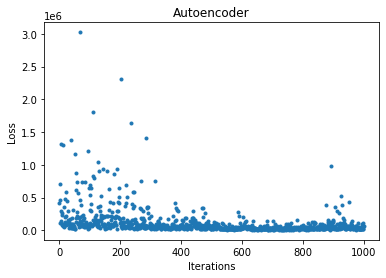

In [19]:
fig = plt.figure()
plt.plot(losses, '.')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Autoencoder")
fig.savefig('Auto_losses.png')

# WGAN

In [22]:
netD = Discriminator(emb_dim).to(DEVICE)
netG = Generator(emb_dim, random_dim).to(DEVICE)

In [23]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)
loss_G=[]
loss_D=[]
epochs = []

one = torch.tensor(1, dtype=torch.float)
mone = one * -1
one = one.to(DEVICE)
mone = mone.to(DEVICE)

In [24]:
def inf_train_gen():
    while True:
        for images,targets in train_loader:
            yield images

In [25]:
def calc_gradient_penalty(netD, real_data, fake_data):
    #print real_data.size()
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(DEVICE)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = interpolates.to(DEVICE)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(DEVICE),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [26]:
netD = netD.to(DEVICE)
netG = netG.to(DEVICE)
data = inf_train_gen()
for iteration in range(ITERS):
    epochs.append(iteration)
    start_time = time.time()
    # (1) Update D network
    for p in netD.parameters():
        p.requires_grad = True

    for iter_d in range(CRITIC_ITERS):
        _data = next(data)
        _data = _data.to(DEVICE)
        _data = encoder(_data).detach()
        real_data = torch.Tensor(_data)
        real_data = real_data.to(DEVICE)
        real_data_v = autograd.Variable(real_data).to(DEVICE)

        netD.zero_grad()

        # train with real
        D_real = netD(real_data_v)
        D_real = D_real.mean()
        # print D_real
        D_real.backward(mone)

        # train with fake
        noise = torch.randn(batch_size, random_dim).to(DEVICE)
        fake = netG(noise).detach()
        inputv = fake
        D_fake = netD(inputv)
        D_fake = D_fake.mean()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optimizerD.step()
        
    loss_D.append(D_cost.item())

    # (2) Update G network
    for p in netD.parameters():
        p.requires_grad = False  # to avoid computation
    netG.zero_grad()

    _data = next(data)
    noise = torch.randn(batch_size, random_dim).to(DEVICE)
    noisev = autograd.Variable(noise).to(DEVICE)
    fake = netG(noisev)
    G = netD(fake)
    G = G.mean()
    G.backward(mone)
    G_cost = -G
    loss_G.append(G_cost.item())
    optimizerG.step()
    if iteration % 50 == 0:
        print(G_cost.item(), D_cost.item())

0.08299410343170166 3.046058177947998
0.09135700762271881 2.1436538696289062
0.06608212739229202 4.514854431152344
0.04812612012028694 5.013648986816406
0.016852665692567825 6.229224681854248
0.01069396361708641 5.249382972717285
0.01669703982770443 7.214844703674316
0.017248213291168213 6.6607232093811035
0.02947184443473816 5.860902786254883
0.04709556698799133 6.274649620056152
0.03970951586961746 6.8524861335754395
0.01894143596291542 5.7188544273376465
0.022896038368344307 5.5374321937561035
0.032883889973163605 7.333178997039795
-0.03841786831617355 7.37493896484375
0.05699250474572182 5.738504409790039
0.06154529005289078 6.0540924072265625
0.043490294367074966 6.439740180969238
0.10845838487148285 7.153253555297852
0.06328199058771133 5.948266983032227


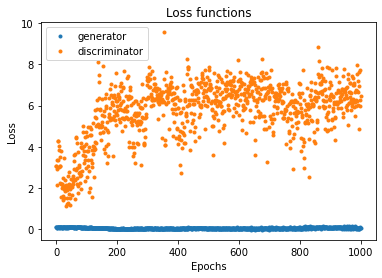

In [27]:
fig = plt.figure()
plt.plot(loss_G, '.', label='generator')
plt.plot(loss_D, '.',  label='discriminator')
plt.title('Loss functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
fig.savefig('losses.png')

In [28]:
torch.save(netG.state_dict(), 'wgan_auto.pth')

## Check

In [29]:
x = torch.randn(10, random_dim).to(DEVICE)

In [30]:
noise = netG(x)

In [31]:
a = decoder(noise).cpu().detach().numpy()

In [32]:
a = scaler.inverse_transform(a)

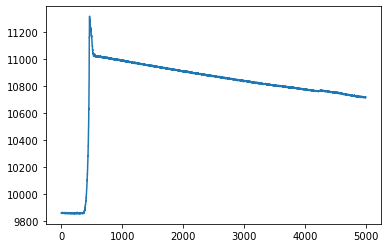

In [35]:
plt.plot(a[2])

In [36]:
a[0] - a[1]

array([10.178711,  8.037109,  9.50293 , ..., 15.171875, 18.125977,
       15.625   ], dtype=float32)